In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wrangle
import prepare_ravinder
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, roc_auc_score
sns.set()
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import plot_tree
from lightgbm import plot_importance
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

In [2]:
# Get raw data from csv file
df = wrangle.get_raw_data()

In [3]:
# Get data dictionary:
data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')

In [4]:
# Get the list of categorical features

df_obj = data_dict[(data_dict['Data Type'] == 'string') | (data_dict['Data Type'] == 'binary')]
cat_features = list(df_obj['Variable Name'].values)
for c in cat_features:
    if c not in data_dict.columns or c == 'hospital_death':
        cat_features.remove(c)
cat_features.remove('bmi')
print(f'cat_features: {cat_features}')

cat_features: ['ethnicity', 'hospital_admit_source', 'icu_admit_type', 'icu_type', 'apache_2_diagnosis', 'apache_post_operative', 'gcs_unable_apache', 'ventilated_apache', 'cirrhosis', 'hepatic_failure', 'leukemia', 'solid_tumor_with_metastasis', 'apache_2_bodysystem']


In [5]:
# prepare data and do some inputations
# df_prep = wrangle.prepare_data_imp(df)

In [6]:
# Some data cleaning and processing done, but no imputation
df = wrangle.prepare_data(df)

In [7]:
# Create new features
df['gcs'] = df.gcs_eyes_apache + df.gcs_motor_apache + df.gcs_verbal_apache
df['almost_dead'] = np.where(((df.temp_apache <= 38) & ((df.ph_apache < 7.1) | (df.ph_apache < 7.3 )) & (df.temp_apache<35) |((df.ph_apache < 7.1 )) & (df.map_apache < 50) | ((df.ph_apache < 7.2 )) & (df.gcs < 5) | (df.pre_icu_los_days > 40)) | ((df.d1_lactate_max > 8) | (df.d1_lactate_min > 10)),True,False)
df['arterial_bp'] = np.where((df.d1_mbp_invasive_max.notnull()), True, False)
df['ventilated_apache'] = np.where(((df['ventilated_apache'].isnull()) & (df.h1_arterial_po2_min.notnull())), 1.0, df['ventilated_apache'])
df['ventilated_apache'] = np.where((df['ventilated_apache'].isnull()), 0.0, df['ventilated_apache'])
df['bool_'+ 'h1_lactate_max'] = np.where(pd.notnull(df['h1_lactate_max']), True, False)

In [8]:
#consolidate some categories for icu_type and 'hospital_admit_source'

df['icu_type']=df['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})

df['hospital_admit_source']= df['hospital_admit_source'].replace({
                                        'Other ICU':"ICU",'ICU to SDU':"SDU",
                                       'Step-Down Unit (SDU)':"SDU",
                                      'Acute Care/Floor':"Floor",
                                      'Other Hospital':"Other"})

In [9]:
# list of variables missing more than 80% values
missing = []
for col in df.columns:
    if df[col].isnull().mean() > 0.8:
        missing.append(col)
missing

['h1_diasbp_invasive_max',
 'h1_diasbp_invasive_min',
 'h1_mbp_invasive_max',
 'h1_mbp_invasive_min',
 'h1_sysbp_invasive_max',
 'h1_sysbp_invasive_min',
 'h1_albumin_max',
 'h1_albumin_min',
 'h1_bilirubin_max',
 'h1_bilirubin_min',
 'h1_bun_max',
 'h1_bun_min',
 'h1_calcium_max',
 'h1_calcium_min',
 'h1_creatinine_max',
 'h1_creatinine_min',
 'h1_hco3_max',
 'h1_hco3_min',
 'h1_hematocrit_max',
 'h1_hematocrit_min',
 'h1_lactate_max',
 'h1_lactate_min',
 'h1_platelets_max',
 'h1_platelets_min',
 'h1_wbc_max',
 'h1_wbc_min',
 'h1_arterial_pco2_max',
 'h1_arterial_pco2_min',
 'h1_arterial_ph_max',
 'h1_arterial_ph_min',
 'h1_arterial_po2_max',
 'h1_arterial_po2_min',
 'h1_pao2fio2ratio_max',
 'h1_pao2fio2ratio_min']

In [10]:
# other columns to remove
to_remove=['icu_id','patient_id','encounter_id','apache_4a_hospital_death_prob','apache_4a_icu_death_prob','readmission_status', 'apache_2_bodysystem', 'hospital_id' ]

In [11]:
#list of variables identified, values of which will be identified against the mean for patients with same diagnosis
apache = [ 'age', 'bmi', 'height','weight', 'albumin_apache','arf_apache','bilirubin_apache','bun_apache',
          'creatinine_apache','fio2_apache','glucose_apache', 'heart_rate_apache','hematocrit_apache',
         'intubated_apache', 'map_apache','paco2_apache','pao2_apache','ph_apache','resprate_apache',
          'sodium_apache','temp_apache','urineoutput_apache','ventilated_apache', 'wbc_apache']

In [12]:
# get list of diagnosis in data
diagnosis = df.apache_2_diagnosis.value_counts().index
diagnosis = diagnosis.astype(str)

In [13]:
# create a empty dataframe (with NaNs) with index as apache variables and columns as diagnosis
df_means = pd.DataFrame(index=apache, columns= diagnosis)
df_means.head(2)

,113.0,301.0,302.0,112.0,308.0,117.0,124.0,122.0,303.0,110.0,304.0,203.0,202.0,106.0,305.0,114.0,121.0,123.0,102.0,307.0,119.0,120.0,118.0,108.0,214.0,109.0,105.0,213.0,207.0,306.0,218.0,217.0,209.0,219.0,101.0,104.0,103.0,115.0,116.0,107.0,215.0,208.0,212.0,216.0
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Fill the empty dataframe created above with mean values of for patients with same diagnosis:
for d in diagnosis:
    for a in apache:
        df_means[d][a] = df[df.apache_2_diagnosis == float(d)][a].mean()

df_means.head(2)

,113.0,301.0,302.0,112.0,308.0,117.0,124.0,122.0,303.0,110.0,304.0,203.0,202.0,106.0,305.0,114.0,121.0,123.0,102.0,307.0,119.0,120.0,118.0,108.0,214.0,109.0,105.0,213.0,207.0,306.0,218.0,217.0,209.0,219.0,101.0,104.0,103.0,115.0,116.0,107.0,215.0,208.0,212.0,216.0
age,64.6395,63.3042,63.2816,63.748,63.7793,69.7777,66.4985,41.9204,62.2462,68.8166,61.621,69.3032,68.8343,65.558,58.7136,62.5583,66.0796,43.7127,66.9973,60.3408,57.4853,52.1251,53.2238,63.3758,68.1451,56.4745,61.6461,66.2956,54.7947,61.2651,57.434,59.9051,64.62,61.2571,44.573,67.8795,59.6049,66.5285,65.6256,63.9492,68.6497,49.6942,60.7653,53.3462
bmi,29.1053,28.9512,29.7945,29.4347,30.5397,29.4761,28.0408,27.844,29.068,31.4086,29.5544,29.1144,28.468,28.8172,31.3788,29.9581,27.4484,27.2402,30.0142,28.502,26.4958,27.7413,27.9283,30.1016,28.0588,30.8019,32.7656,28.4348,27.7849,28.3742,30.0609,28.414,28.2362,30.5285,31.506,26.8084,31.486,29.1809,28.2941,25.8731,29.5407,27.0977,29.0655,27.1413


In [15]:
# create new columns named diff_col_name which is difference between apache variables and
# corresponding mean values for patients with same diagnosis:
for a in apache:
    for d in diagnosis:
        df['diff_'+ a] = np.where(df[a].notnull(), df_means[d][a]-df[a], 0)

In [16]:
# drop columns which are missing more than 80% values
df.drop(columns = missing,axis=1,inplace=True)

In [17]:
# Drop columns with 'invasive in their names since they are redundant'
inv_cols=[s for s in df.columns.tolist() if "invasive" in s]
df.drop(inv_cols,axis=1,inplace=True)

In [18]:
df.head(2)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_inr_max,h1_inr_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,gcs,almost_dead,arterial_bp,bool_h1_lactate_max,diff_age,diff_bmi,diff_height,diff_weight,diff_albumin_apache,diff_arf_apache,diff_bilirubin_apache,diff_bun_apache,diff_creatinine_apache,diff_fio2_apache,diff_glucose_apache,diff_heart_rate_apache,diff_hematocrit_apache,diff_intubated_apache,diff_map_apache,diff_paco2_apache,diff_pao2_apache,diff_ph_apache,diff_resprate_apache,diff_sodium_apache,diff_temp_apache,diff_urineoutput_apache,diff_ventilated_apache,diff_wbc_apache
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CCT-CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,68.0,37.0,119.0,72.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,39.9,37.2,68.0,63.0,119.0,108.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,13.0,False,True,False,-14.653846,4.411262,-12.047692,3.11625,0.761905,0.576923,0.491667,10.846154,2.958462,0.00,33.115385,-26.653846,0.903846,0.115385,66.807692,0.0,0.0,0.0000,-12.615385,3.5,-2.810769,0.0,0.230769,-1.559615
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1.0,12.7,95.0,31.0,118.0,72.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,36.3,35.1,61.0,48.0,114.0,100.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,36.3,36.3,1.6,1.6,0.5,0.5,11.0,9.0,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,1.3,1.3,3.5,3.5,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,145.0,143.0,11.3,11.3,1.3,1.3,4.2,4.2,145.0,145.0,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.0,0.47,0.29,0.0,0.0,1.0,0.0,0.0,0.0,0

In [19]:
# all features/columns in df
features = [col for col in df.columns]

In [20]:
# Function which takes all numerical columns and returns columns with correlation higher than 0.99
def drop_correlated_features(df):
    num_feature = [col for col in features if col not in cat_features and df[col].dtype != 'object']
    drop_columns=[]
    corr = df[num_feature].corr()

    columns = np.full((corr.shape[0],), True, dtype=bool)

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >=0.99 :
                if columns[j] == True:
                    columns[j] = False
                    print('col1: {} col2: {} - Correlation: {}'.format(df[num_feature].columns[i] , df[num_feature].columns[j], corr.iloc[i,j]))
            elif corr.iloc[i,j] <= -0.99:
                if columns[j] == True:
                    columns[j] = False

    drop_columns = df[num_feature].columns[columns == False].values
    return drop_columns

In [21]:
#list of correlated columns returned from function above
drop_columns = drop_correlated_features(df)

col1: bilirubin_apache col2: d1_bilirubin_max - Correlation: 0.9965677029378415
col1: bun_apache col2: d1_bun_max - Correlation: 0.9911211474368951
col1: creatinine_apache col2: d1_creatinine_max - Correlation: 0.9941463711670832
col1: paco2_apache col2: paco2_for_ph_apache - Correlation: 1.0
col1: d1_inr_max col2: h1_inr_max - Correlation: 1.0
col1: d1_inr_min col2: h1_inr_min - Correlation: 1.0


In [22]:
#list of highly correlated variables
drop_columns

array(['paco2_for_ph_apache', 'd1_bilirubin_max', 'd1_bun_max',
       'd1_creatinine_max', 'h1_inr_max', 'h1_inr_min', 'diff_age',
       'diff_bmi', 'diff_height', 'diff_weight', 'diff_albumin_apache',
       'diff_arf_apache', 'diff_bilirubin_apache', 'diff_bun_apache',
       'diff_creatinine_apache', 'diff_fio2_apache',
       'diff_glucose_apache', 'diff_heart_rate_apache',
       'diff_hematocrit_apache', 'diff_intubated_apache',
       'diff_map_apache', 'diff_paco2_apache', 'diff_pao2_apache',
       'diff_ph_apache', 'diff_resprate_apache', 'diff_sodium_apache',
       'diff_temp_apache', 'diff_urineoutput_apache', 'diff_wbc_apache'],
      dtype=object)

In [23]:
#drop columns identified above
features = [col for col in features if col not in drop_columns]
df = df[features]

# drop diff_ventilated_apache columns since it is categorical
df = df.drop(columns = 'diff_ventilated_apache')
df = df.drop(columns = to_remove)


In [24]:
#check df
df.head(2)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,gcs,almost_dead,arterial_bp,bool_h1_lactate_max
0,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,admit,CCT-CTICU,0.541667,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,68.0,37.0,119.0,72.0,89.0,46.0,34.0,10.0,100.0,74.0,131.0,73.0,39.9,37.2,68.0,63.0,119.0,108.0,86.0,85.0,26.0,18.0,100.0,74.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,30.0,8.5,7.4,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,13.0,False,True,False
1,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,admit,Med-Surg ICU,0.927778,70.2,NaN,108.0,203.01,0,0.0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0.0,46.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1.0,12.7,95.0,31.0,118.0,72.0,120.0,38.0,32.0,12.0,100.0,70.0,159.0,67.0,36.3,35.1,61.0,48.0,114.0,100.0,85.0,57.0,31.0,28.0,95.0,70.0,95.0,71.0,36.3,36.3,1.6,1.6,0.5,9.0,8.6,8.0,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,1.3,1.3,3.5,3.5,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,145.0,143.0,11.3,11.3,4.2,4.2,145.0,145.0,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,5.0,False,False,True


In [25]:
# identify binary and categorical features
binary=[col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes !='object']
categorical = [col for col in df.columns if df[col].dtypes == 'object']

# assign features to correct types
categorical.append('apache_2_diagnosis')
binary.remove('hospital_death')


In [26]:
#list of binary features
binary

['elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'almost_dead',
 'arterial_bp',
 'bool_h1_lactate_max']

In [27]:
#list of categorical features
categorical

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_3j_diagnosis',
 'apache_3j_bodysystem',
 'apache_2_diagnosis']

In [28]:
# for binary columns specify 0 as missing, 1 as 'no' and 2 as 'yes'
for col in binary:
    df[col]= df[col]+1
    df[col].fillna(0,inplace=True)
#     df[col]= df[col].astype(str)
    df[col]= df[col].astype(np.int64).astype('category')

In [29]:
# convert binary columns to int type
df['gcs_unable_apache'] = df['gcs_unable_apache'].astype('Int64')
for b in binary:
    df[b] = df[b].astype('Int64')

In [30]:
#identify numeric columns
numeric_col =[col for col in df.columns if  df[col].dtypes !='object' and col not in binary and col not in categorical]

In [31]:
#create test train split
train, test = train_test_split(df, train_size = .80, random_state = 42, stratify = df.hospital_death)

In [32]:
#make DF for numerical columns only so that we can do scaling
numeric_train = train[numeric_col]
numeric_test = test[numeric_col]
numeric_train.head(2)

,hospital_death,age,bmi,height,pre_icu_los_days,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_temp_max,d1_temp_min,h1_diasbp_max,h1_diasbp_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_min,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,gcs
59226,1,72.0,32.041330,154.9,0.061111,76.88,2.0,2.4,26.0,1.64,NaN,4.0,6.0,4.0,107.0,99.0,27.9,45.0,NaN,NaN,NaN,13.0,135.0,36.6,NaN,22.81,95.0,13.0,150.0,77.0,101.0,22.0,40.0,12.0,100.0,38.0,161.0,48.0,36.7,35.8,51.0,39.0,94.0,92.0,59.0,47.0,19.0,16.0,98.0,96.0,85.0,72.0,NaN,NaN,2.0,2.0,2.4,26.0,7.1,7.1,1.64,132.0,107.0,20.0,20.0,13.7,8.8,43.6,27.9,1.8,1.8,2.6,2.6,81.0,81.0,4.1,4.1,135.0,135.0,22.81,22.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
81334,0,58.0,34.334291,190.5,0.032639,124.60,2.5,1.2,70.0,2.85,NaN,1.0,1.0,1.0,319.0,138.0,37.4,47.0,NaN,NaN,NaN,53.0,117.0,36.2,NaN,16.20,137.0,14.0,138.0,83.0,144.0,42.0,53.0,17.0,99.0,81.0,161.0,77.0,37.8,36.2,64.0,22.0,128.0,116.0,86.0,42.0,53.0,30.0,98.0,96.0,121.0,96.0,37.8,37.4,2.6,2.5,1.0,63.0,8.5,8.1,2.44,319.0,212.0,36.0,32.0,11.9,11.9,37.4,37.4,1.4,1.4,2.7,1.9,358.0,358.0,4.3,4.1,152.0,123.0,16.20,16.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [33]:
# dataframe for binary columns which allows us to do onehotencoding
binary_train = train[binary]
binary_test = test[binary]
binary_train.head(2)

,elective_surgery,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,almost_dead,arterial_bp,bool_h1_lactate_max
59226,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1
81334,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1


In [34]:
# dataframe for categorical columns which allows us to do onehotencoding
categorical_train = train[categorical]
categorical_test = test[categorical]
categorical_train.head(2)

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,apache_3j_diagnosis,apache_3j_bodysystem,apache_2_diagnosis
59226,Caucasian,F,SDU,Floor,admit,MICU,501.02,Sepsis,113.0
81334,Caucasian,M,Direct Admit,Accident & Emergency,admit,Med-Surg ICU,501.01,Sepsis,113.0


In [35]:
# Fill categorical missing data with most frequent values 'mode'
for col in categorical_train:
    categorical_train[col].fillna(categorical_train[col].mode()[0],inplace=True)
    
for col in categorical_test:
    categorical_test[col].fillna(categorical_test[col].mode()[0],inplace=True)

In [36]:
# Scale numerical columns in both train and test

scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_train)
numeric_train_scaled = pd.DataFrame(scaler.transform(numeric_train), columns=numeric_train.columns.values).set_index([numeric_train.index.values])

scaler1 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_test)
numeric_test_scaled = pd.DataFrame(scaler1.transform(numeric_test), columns=numeric_test.columns.values).set_index([numeric_test.index.values])

In [37]:
# check shape of the train dataframes
numeric_train.shape, categorical_train.shape, binary_train.shape

((73370, 98), (73370, 9), (73370, 17))

In [38]:
#create a list of columns which need to be onehotencoded
encode_columns = (list(binary_train.columns) + list(categorical_train.columns))

In [39]:
# concat the categorical and binary DF
train_concat = pd.concat([categorical_train, binary_train], axis =1)
test_concat = pd.concat([categorical_test, binary_test], axis =1)

In [40]:
# convert apache_3j_diagnosis as str type before hot encoding for train and test
train_concat.apache_3j_diagnosis = train_concat.apache_3j_diagnosis.astype(str)
test_concat.apache_3j_diagnosis = test_concat.apache_3j_diagnosis.astype(str)

In [41]:
#hot encode train and test non-numerical features for train and test
train_encoded = prepare_ravinder.encode(train_concat, encode_columns)
test_encoded = prepare_ravinder.encode(test_concat, encode_columns)

In [42]:
# concat numeric scaled and onehot encoded features for train and test
train = pd.concat([numeric_train_scaled ,train_encoded], axis =1)
test = pd.concat([numeric_test_scaled ,test_encoded], axis =1)

## Modeling

In [113]:
# Create X (predictors) and y (target)
y = train[['hospital_death']]
X = train.drop(columns = ['hospital_death'])

y_test = test[['hospital_death']]
X_test = test.drop(columns = ['hospital_death'])

In [114]:
#check shape
X.shape, y.shape

((73370, 331), (73370, 1))

### Light GBM 

In [115]:
import lightgbm as lgb
d_train = lgb.Dataset(X, label=y)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 6
params['min_child_weight'] = 1
params['n_estimators'] = 350
clf = lgb.train(params, d_train, 350)

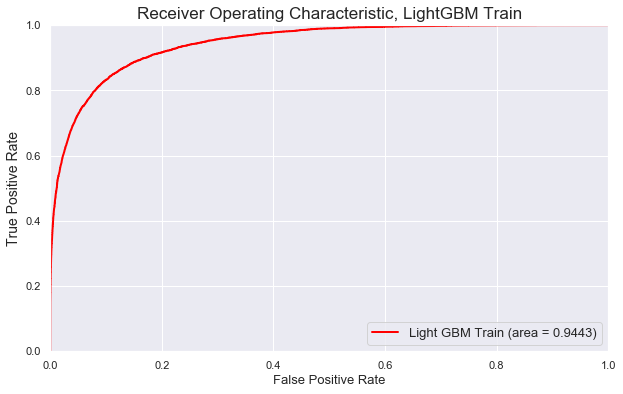

In [116]:
# Plot ROC for train data
plt.figure(figsize=(10,6))
y_pred=clf.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic, LightGBM Train', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

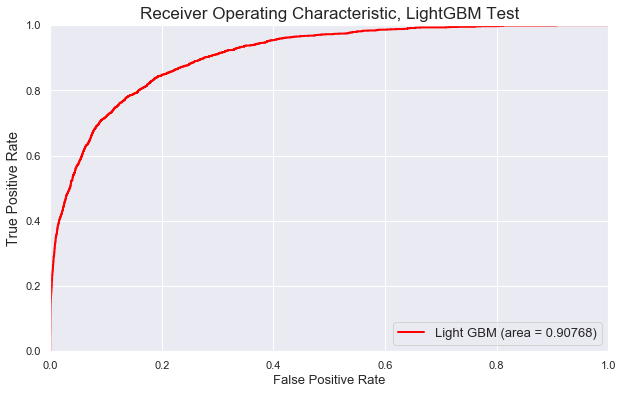

In [117]:
plt.figure(figsize=(10,6))

y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM (area = %0.5f)' % auc(fpr, tpr))
         
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic, LightGBM Test', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

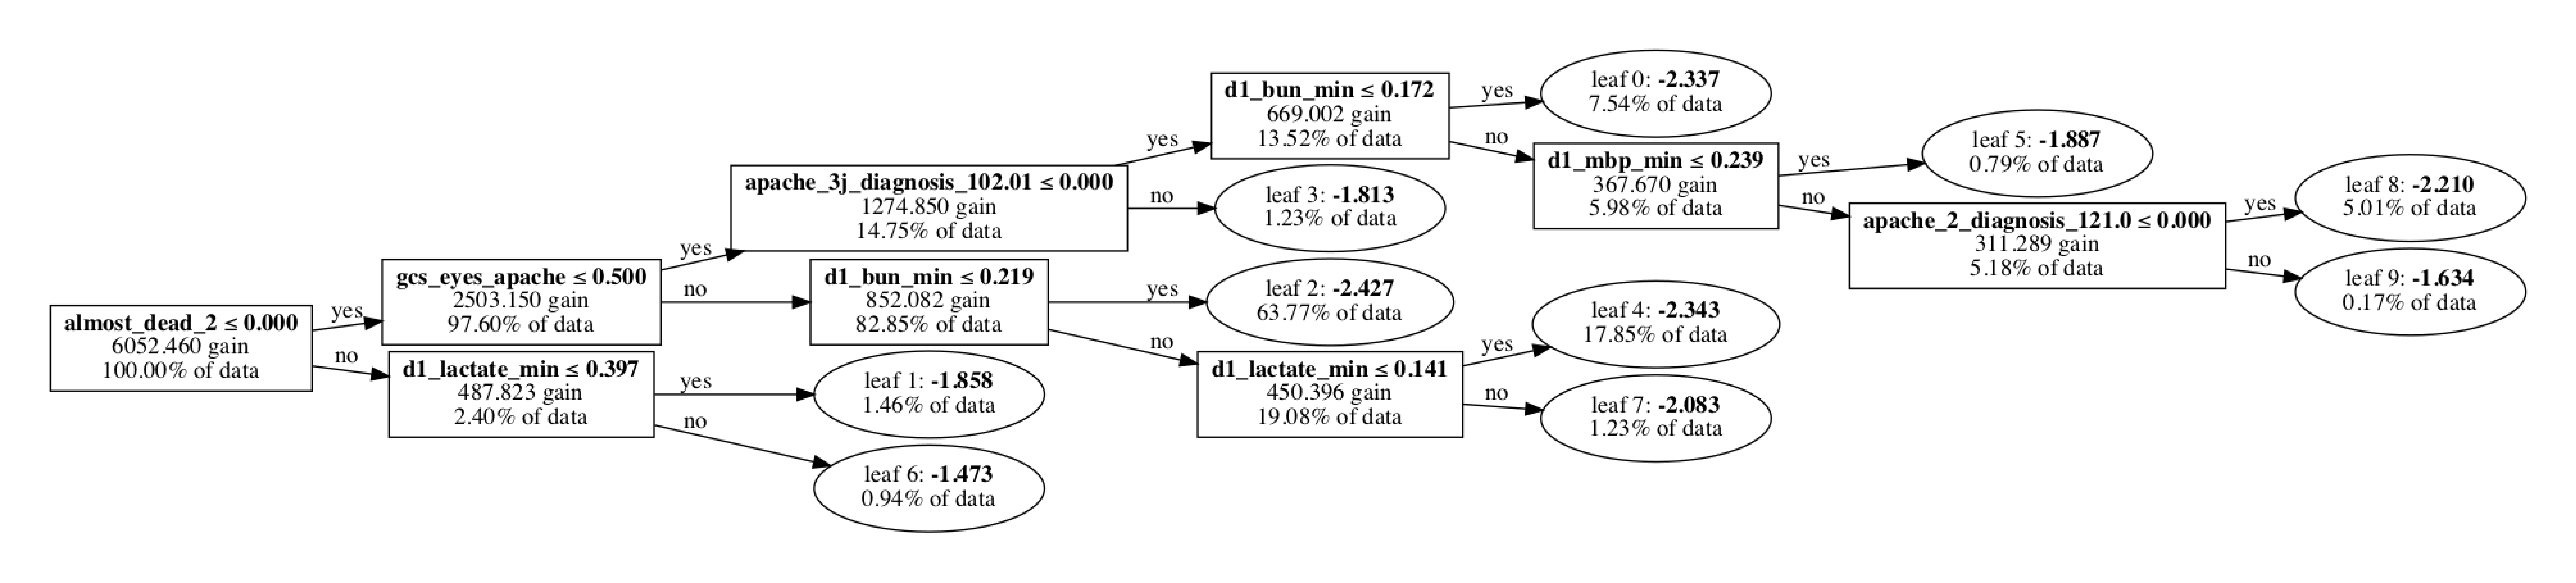

In [112]:
# plot single tree
fig = plt.figure(dpi=1800)
ax = plt.subplot(1,1,1)
plot_tree(clf, ax = ax, show_info = ['split_gain', 'data_percentage'])
plt.tight_layout()
# plt.savefig('lgm_tree.png')
plt.show()

In [120]:
def get_feature_importances(data, shuffle,y, seed=None):
    # Gather real features
    train_features = [f for f in data]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
#     y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = y['hospital_death'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(train[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    categorical_feats =[]
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [121]:
# random seed
np.random.seed(42)
# Get the  importance scores
actual_imp_df = get_feature_importances(data=X, y = y,shuffle=False)

In [123]:
actual_imp_df.head(4)

,feature,importance_gain,importance_split,trn_score
0,age,45497.609859,1181,0.897466
1,bmi,9772.502949,358,0.897466
2,height,2836.270544,137,0.897466
3,pre_icu_los_days,11281.627826,330,0.897466


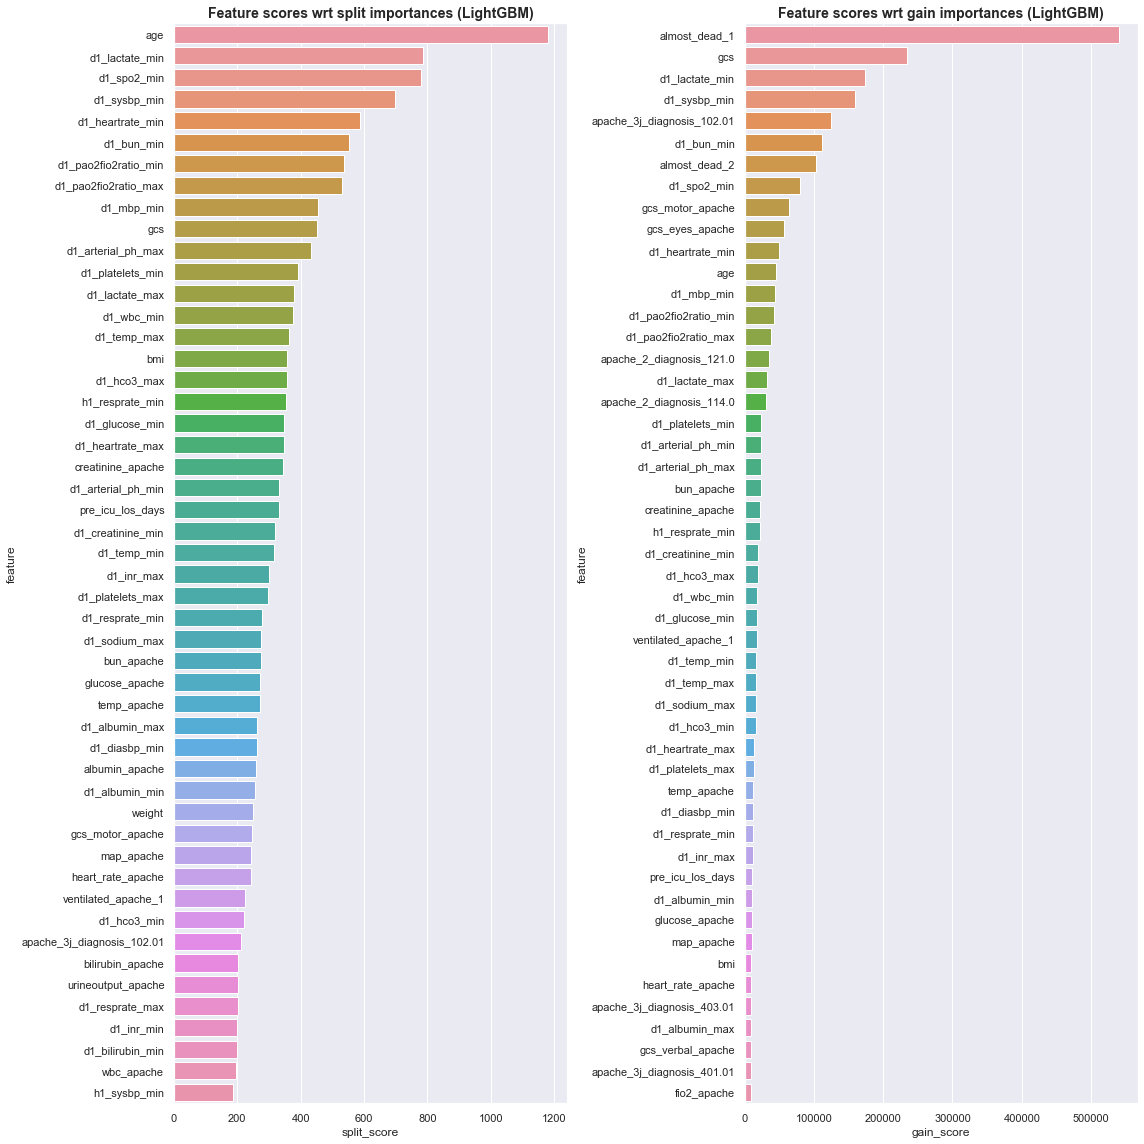

In [125]:
# Plot feature importance
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = f_act_imps_gain  
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score =  f_act_imps_split  
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)

# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:50], ax=ax)
ax.set_title('Feature scores wrt split importances (LightGBM)', fontweight='bold', fontsize=14)

# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:50], ax=ax)
ax.set_title('Feature scores wrt gain importances (LightGBM)', fontweight='bold', fontsize=14)
plt.tight_layout()

## XGBoost

In [50]:
#create and fit a XGBoost object
model = XGBClassifier(learning_rate =0.1, n_estimators=177, max_depth=7,
 min_child_weight=5, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, reg_alpha=0.0001, seed=27)
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=177, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0.0001, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [51]:
#predict for train data
y_pred = model.predict(X)

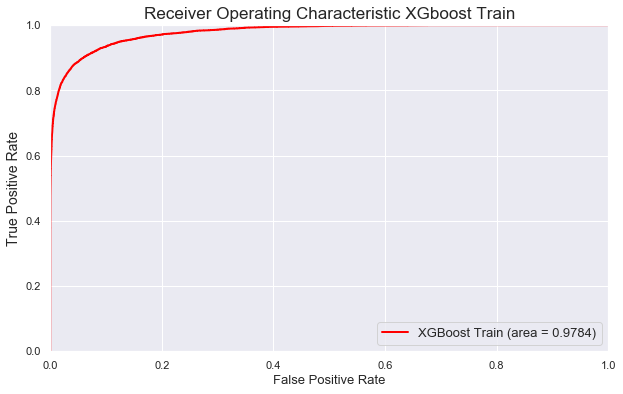

In [135]:
#plot ROC for train data

plt.figure(figsize=(10,6))
y_pred = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Train (area = %0.4f)' % auc(fpr, tpr))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic XGboost Train', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

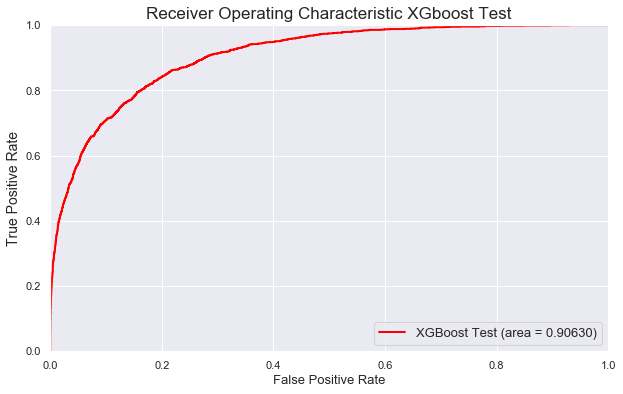

In [136]:
#plot ROC for test data
plt.figure(figsize=(10,6))

y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='XGBoost Test (area = %0.5f)' % auc(fpr, tpr))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic XGboost Test', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [127]:
# Feature importance for XGboost
sorted_idx = np.argsort(model.feature_importances_)[::-1]
f_imp = []
for index in sorted_idx:
    f_imp.append([X.columns[index], model.feature_importances_[index]])

feature_importance = pd.DataFrame(f_imp)
feature_importance.columns = ['feature', 'importance']

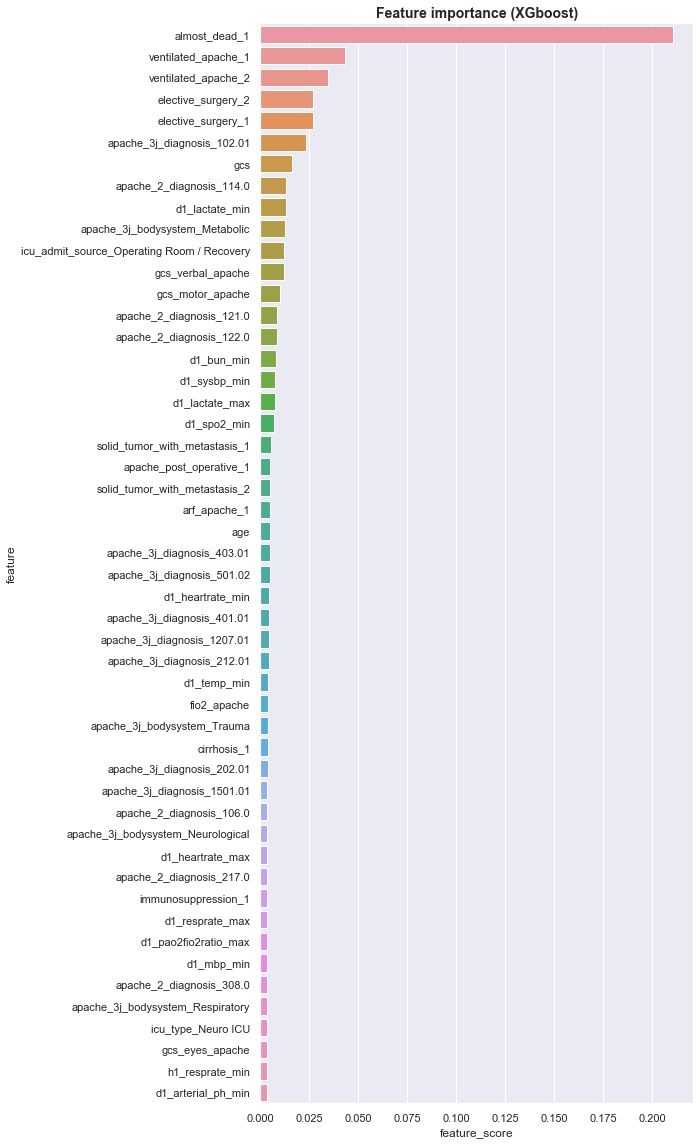

In [131]:
# Plot feature importance for XGboost
feature_scores = []
for _f in feature_importance['feature'].unique():
    f_act_imps_gain = feature_importance.loc[feature_importance['feature'] == _f, 'importance'].mean()
    feature_score = f_act_imps_gain  
   
    feature_scores.append((_f, feature_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'feature_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)

# Plot importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='feature_score', y='feature', data=scores_df.sort_values('feature_score', ascending=False).iloc[0:50], ax=ax)
ax.set_title('Feature importance (XGboost)', fontweight='bold', fontsize=14)
plt.tight_layout()

## Logistic Regression
#### Logistic regression cannot handle NaNs, so we need to impute NaNs before modeling:-

In [58]:
#Imputation for numerical columns in train 
imp = IterativeImputer(max_iter=3, verbose=1)
imp.fit(numeric_train)
imputed_train = imp.transform(numeric_train)
imputed_train = pd.DataFrame(imputed_train, columns=numeric_train.columns, index = numeric_train.index)

[IterativeImputer] Completing matrix with shape (73370, 98)
[IterativeImputer] Change: 3148.6805895674647, scaled tolerance: 8.716669631999999 
[IterativeImputer] Change: 4787.515519169886, scaled tolerance: 8.716669631999999 
[IterativeImputer] Change: 19365.27528220752, scaled tolerance: 8.716669631999999 
[IterativeImputer] Completing matrix with shape (73370, 98)


In [59]:
#Imputation for numerical columns in test
impt = IterativeImputer(max_iter=3, verbose=1)
impt.fit(numeric_test)
imputed_test = impt.transform(numeric_test)
imputed_test = pd.DataFrame(imputed_test, columns=numeric_test.columns, index = numeric_test.index)

[IterativeImputer] Completing matrix with shape (18343, 98)
[IterativeImputer] Change: 2579.3901797861895, scaled tolerance: 8.716669631999999 
[IterativeImputer] Change: 8351.00573728371, scaled tolerance: 8.716669631999999 
[IterativeImputer] Change: 9003.449344791725, scaled tolerance: 8.716669631999999 
[IterativeImputer] Completing matrix with shape (18343, 98)


In [60]:
#scale the imputed numeric test and train columns
scaler3 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_train)
numeric_train_scaled = pd.DataFrame(scaler3.transform(imputed_train), columns=imputed_train.columns.values).set_index([imputed_train.index.values])

scaler4 = MinMaxScaler(copy=True, feature_range=(0,1)).fit(numeric_test)
numeric_test_scaled = pd.DataFrame(scaler4.transform(imputed_test), columns=imputed_test.columns.values).set_index([imputed_test.index.values])

In [61]:
# combine scaled numeric columns with onehot encoded columns for both train and test
imputed_train = pd.concat([numeric_train_scaled ,train_encoded], axis =1)
Imputed_test = pd.concat([numeric_test_scaled ,test_encoded], axis =1)

In [75]:
# check shape
imputed_train.shape, Imputed_test.shape

((73370, 332), (18343, 332))

In [95]:
# make train and test predictor and target dataframes
y = imputed_train[['hospital_death']]
X = imputed_train.drop(columns = ['hospital_death'])

y_test = imputed_test[['hospital_death']]
X_test = Imputed_test.drop(columns = ['hospital_death'])

In [77]:
#check shape
X.shape, X_test.shape

((73370, 331), (18343, 331))

In [106]:
# Create and fit the logistic regression object on train data
logit = LogisticRegression(C = 0.1, class_weight = 'balanced',penalty = 'l2', max_iter=1000)
logit.fit(X, y)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)

In [107]:
# predict for train data
y_pred = logit.predict(X)

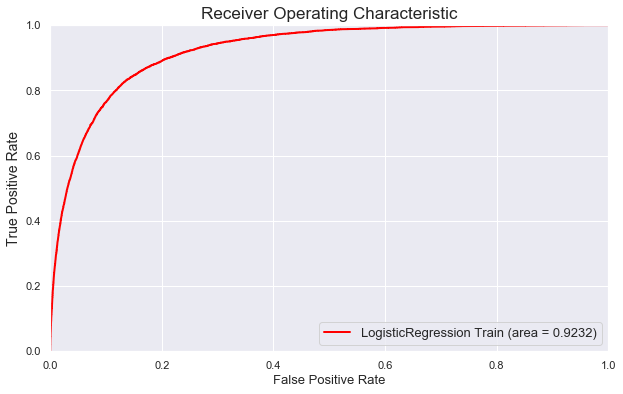

In [108]:
#plot ROC for train data
plt.figure(figsize=(10,6))
y_pred = logit.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Train (area = %0.4f)' % auc(fpr, tpr))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [109]:
#predict for test data
y_pred_test = logit.predict(X_test)

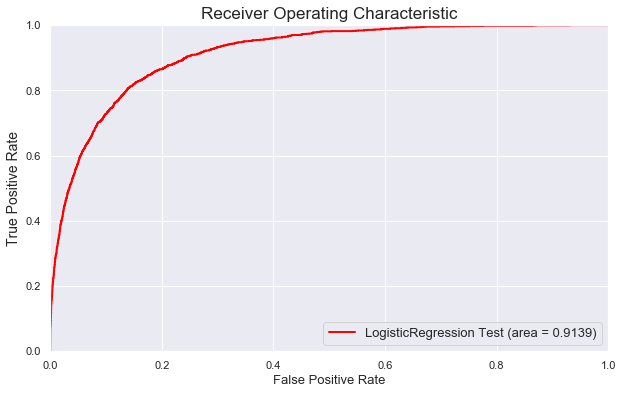

In [110]:
#plot ROC for test data
plt.figure(figsize=(10,6))
y_pred_test = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot(fpr, tpr, color='red', lw=2, label='LogisticRegression Test (area = %0.4f)' % auc(fpr, tpr))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [97]:
#logistic regression feature importance
feature_imp = pd.DataFrame(logit.coef_[0], index = X.columns).reset_index()

In [100]:
#logistic regression feature importance (top 20)
feature_imp.columns = ['feature', 'coeff']
feature_imp.sort_values('coeff').head(20)

,feature,coeff
18,pao2_apache,-3.125437
84,h1_potassium_max,-2.754502
82,h1_hemaglobin_max,-1.760258
62,d1_hco3_max,-1.330893
200,apache_3j_diagnosis_1207.01,-1.196632
90,d1_arterial_ph_max,-1.085437
86,h1_sodium_max,-0.994772
65,d1_hemaglobin_min,-0.992300
5,albumin_apache,-0.956276
34,d1_spo2_min,-0.887021
